# Linear Regression and Stochastic Gradient Descent

In [1]:
#%pip install palmerpenguins

import sys
sys.path.append("../src")

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

from rice_ml.linear_regression import SingleNeuron

sns.set_theme()

### Loading and preparing the dataset

Linear regression is a foundational algorithm in machine learning that models the relationship between input features and a continuous target variable by fitting a straight line to the data. It learns coefficients that minimize the mean squared error between predicted and actual values, providing interpretable insights into feature influence. Unlike the perceptron which classifies data into categories, linear regression predicts numeric outcomes.

We will again use the Palmer Penguins dataset is a great fit because of its inclusion of continuous numeric characteristics that have real world biological implications.

In [2]:
from palmerpenguins import load_penguins

penguins = load_penguins()
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


Now we have an understanding of the Penguins dataset. Each row is an observation of a penguin, as long as some characteristics of that penguin: this includes information about its species, sex, bill legnth, flipper length, etc. Note that continuous numeric characteristics such as bill length and body mass will be of importance for our application in linear regression.

Linear regression find the function that best maps a linear relationship between two variables. Thus, it will be helpful to figure out which characteristics of penguins may have the highest linear correlations so that we can apply our model and achieve useful predictions.

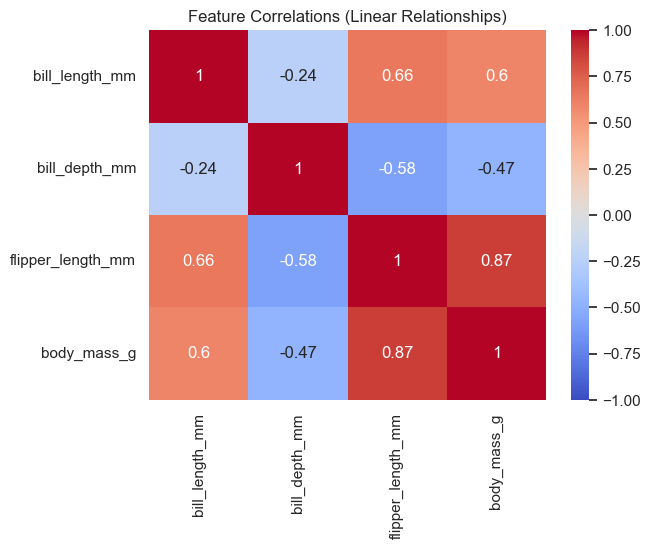

In [3]:
corr = penguins[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlations (Linear Relationships)")
plt.show()

From this heatmap, we can see that flipper length (in millimeters) and body mass (in grams) of the penguins in this dataset has a high linear correlation. Thus, we will isolate these two characteristics of penguins for use in our algorithm.

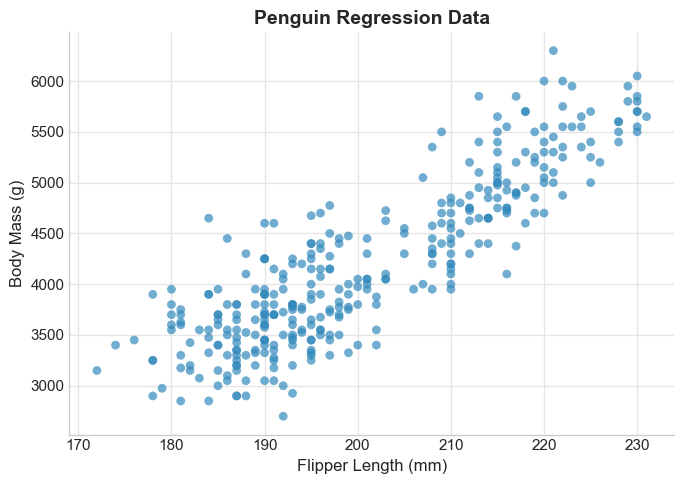

In [4]:
# Scatterplot of flipper length vs body mass
import matplotlib.pyplot as plt

# Use a minimal, ggplot-like style
plt.style.use("seaborn-v0_8-whitegrid")

# Create scatterplot
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(
    penguins["flipper_length_mm"],
    penguins["body_mass_g"],
    s=40,
    color="#348ABD",       # soft blue
    alpha=0.7,
    edgecolor="none"
)

# Minimal theme adjustments
ax.set_title("Penguin Regression Data", fontsize=14, weight="bold")
ax.set_xlabel("Flipper Length (mm)", fontsize=12)
ax.set_ylabel("Body Mass (g)", fontsize=12)

# Remove top and right spines for a minimal look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Make gridlines subtle
ax.grid(True, color="0.9")

plt.tight_layout()
plt.show()


From plotting the flipper length against the body mass of our penguin observations, we can visually confirm that the two variables exhibit a highly linear relationship that can be effectively modeled through linear regression.

In [5]:
from sklearn.model_selection import train_test_split

penguins_ready = penguins[["flipper_length_mm", "body_mass_g"]].dropna().reset_index(drop=True)

# Create a "vector" column where each entry is a NumPy array of features
penguins_ready["vector"] = penguins_ready[["flipper_length_mm"]].apply(lambda row: np.array(row), axis=1)

print(penguins_ready)

# Initialize model
model = SingleNeuron()

# Define which columns in the DataFrame to use
model.vector_col = "vector"
model.target_col = "body_mass_g"

# 3. Split the DataFrame into train/test before calling prepare_data
train_df, test_df = train_test_split(penguins_ready, test_size=0.2, random_state=12)

# 4. Initialize the model
model = SingleNeuron()
model.vector_col = "vector"
model.target_col = "body_mass_g"

# 5. Prepare the arrays for each split
X_train, y_train = model.prepare_data(train_df)
X_test, y_test = model.prepare_data(test_df)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes: ", X_test.shape, y_test.shape)

     flipper_length_mm  body_mass_g   vector
0                181.0       3750.0  [181.0]
1                186.0       3800.0  [186.0]
2                195.0       3250.0  [195.0]
3                193.0       3450.0  [193.0]
4                190.0       3650.0  [190.0]
..                 ...          ...      ...
337              207.0       4000.0  [207.0]
338              202.0       3400.0  [202.0]
339              193.0       3775.0  [193.0]
340              210.0       4100.0  [210.0]
341              198.0       3775.0  [198.0]

[342 rows x 3 columns]
Train shapes: (273, 1) (273,)
Test shapes:  (69, 1) (69,)


We can see that in total, we have 342 observations of penguins in our dataset, 273 of which will be used for traning and 69 of which will be used for testing. In our model, flipper length is serving as the single predictor and body mass as our target characteristic.

After confirming that the x and y vectors contain the appropriate number of rows, we are ready to start training the neuron for linear regression.

### Training

To train our model, we are using stochastic gradient descent, which updates the model’s weights one sample at a time to minimize prediction error. For each training example, the neuron predicts a value using its current weights and bias, compares it to the true body mass, and calculates the error.

The weights are adjusted in the direction that reduces this error by a magnitude determined by the learning rate. Let us start with a learning rate (corresponding to the parameter of alpha in our "train" method) of 10 ^ -7 to take into account the magnitude of our predictor and target data. Let us also start by training our single neuron over 5 epochs, or full passes through the training data. With a high enough number of training epochs, the neuron's weights will accurately model the linear relationship between flipper length and body mass.

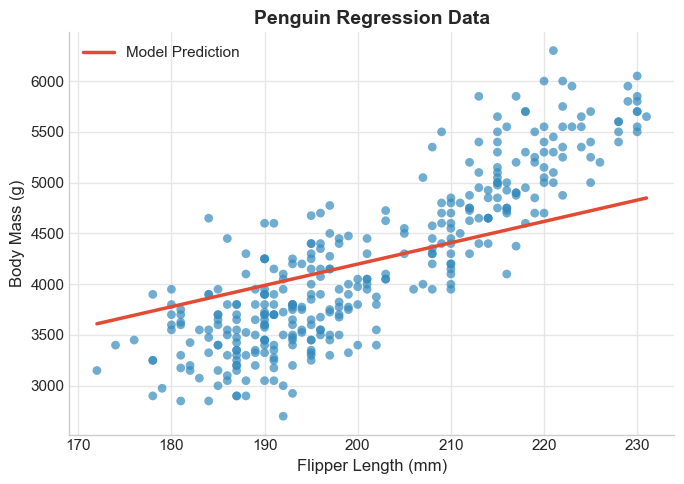

In [21]:
# Training the model
model.train(X_train, y_train, alpha=1e-7, epochs=5, random_state=12)

# Use a minimal, ggplot-like style
plt.style.use("seaborn-v0_8-whitegrid")

# Create scatterplot
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(
    penguins["flipper_length_mm"],
    penguins["body_mass_g"],
    s=40,
    color="#348ABD",       # soft blue
    alpha=0.7,
    edgecolor="none"
)

# Minimal theme adjustments
ax.set_title("Penguin Regression Data", fontsize=14, weight="bold")
ax.set_xlabel("Flipper Length (mm)", fontsize=12)
ax.set_ylabel("Body Mass (g)", fontsize=12)

# Remove top and right spines for a minimal look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Make gridlines subtle
ax.grid(True, color="0.9")

plt.tight_layout()

# Adding the line representing the initial guess of the linear relationship between the variables
x_line = np.linspace(penguins["flipper_length_mm"].min(),
                     penguins["flipper_length_mm"].max(), 100).reshape(-1, 1)
y_line = model.predict(x_line)

ax.plot(x_line, y_line, color="#E24A33", linewidth=2.5, label="Model Prediction")
ax.legend()
plt.show()

After 5 epochs of training, we can see that the model has captured the positive relationship between flipper length and body mass of the penguins. However, the line is not optimized to best fit the data points. As the neuron is trained over a much higher number of epochs, our predictive function would adjust to become a true line of best fit.

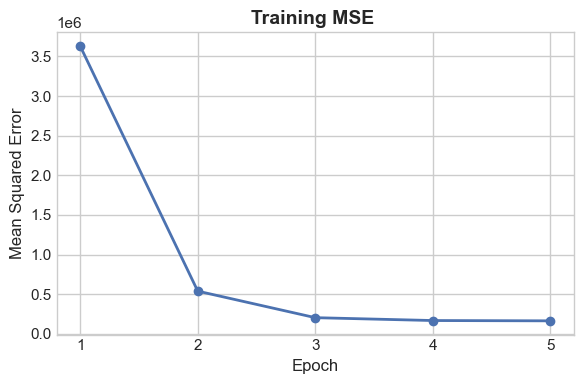

MSE by epoch: [3630929.1   538193.2   203266.36  167118.71  163258.02]


In [27]:
mse = np.asarray(model.errors_)  # length should be 5

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(6,4))
plt.plot(range(1, len(mse)+1), mse, marker="o", linewidth=2)

plt.title("Training MSE ", fontsize=14, weight="bold")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Mean Squared Error", fontsize=12)

plt.xticks(range(1, len(mse)+1))
plt.tight_layout()
plt.show()